In [62]:
# data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats/Regresions Packages
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn import metrics

# make sure charts appear in the notebook:
%matplotlib inline
%config InlineBackend.figure_format ='retina'


from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

import os
import datetime
from scipy.stats import mode
import pickle



#import cluster packages
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')


#### Load the OkCupid user profile data scraped by Emil Kierkegaard.

In [2]:
path='/home/ubuntu/OkCupid_data/user_data_public.csv'
okc2=pd.read_csv(path)

#### We can see that the table is quite sparse with few of the 2,625 features populated for each user profile.

In [3]:
okc2.head()

,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86615,q86699,q363047,CA,gender_orientation,gender,race,gender2,gender2_num,CA_items
0,NaN,Horrified,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,...,NaN,NaN,NaN,0.763080,Hetero_female,Woman,White,Woman,0.0,4.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Hetero_male,Man,NaN,Man,1.0,0.0
2,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,NaN,...,NaN,NaN,NaN,0.661309,Hetero_female,Woman,NaN,Woman,0.0,7.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Hetero_female,Woman,White,Woman,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.875424,Bisexual_female,Woman,NaN,Woman,0.0,3.0


#### Select female profiles interested in men.

In [4]:
okc2=okc2[okc2.gender_orientation.isin(['Hetero_female','Bisexual_female'])]

In [5]:
okc2.shape

(24777, 2625)

#### We can see that about half of profiles answered less than 250 questions. 

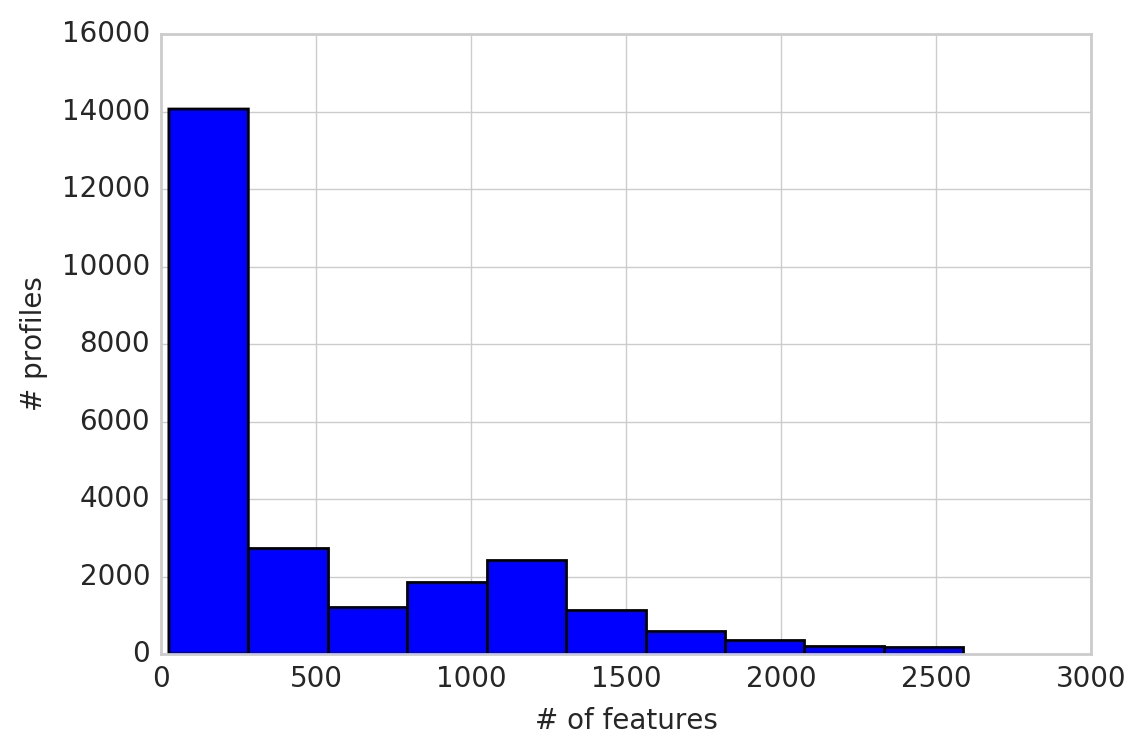

In [6]:
#Count the number of non-null features in each observation
x=okc2.count(axis=1)
#Make a histogram to see the distribution of the number of features against the number profiles. 
plt.hist(x)
plt.ylabel('# profiles')
plt.xlabel('# of features')

In [7]:
x=okc2.T


In [8]:
x.head()

,0,2,3,4,8,10,12,13,15,17,...,68339,68342,68345,68350,68352,68353,68358,68362,68367,68369
q2,NaN,NaN,NaN,NaN,NaN,more pathetic than cool,more pathetic than cool,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q11,Horrified,NaN,NaN,NaN,NaN,Horrified,Aroused,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q12,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q13,NaN,No,NaN,NaN,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q14,NaN,No,NaN,NaN,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Load the question data so that I can see the question text and the possible answers. As we can see, it's almost entirely categorical.

In [9]:
path='/home/ubuntu/OkCupid_data/question_data.csv'
questions=pd.read_csv(path,delimiter=';')

In [10]:
questions.head(20)


,Unnamed: 0,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
0,q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
1,q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
2,q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
3,q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
4,q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy
5,q16,Should sex with someone 16 years old be a jail...,Yes,No,NaN,NaN,8341,O,NaN,sex/intimacy
6,q17,Would you date someone just for the sex?,Yes,No,NaN,NaN,38180,O,NaN,sex/intimacy
7,q18,Do you have experience being in a slave/master...,Yes,No,NaN,NaN,21686,O,NaN,sex/intimacy; BDSM
8,q20,"BDSM: Without looking it up, do you know exact...",Yes,No,NaN,NaN,16643,O,NaN,sex/intimacy; BDSM
9,q21,Do you enjoy meaningless sex?,Yes,No,NaN,NaN,31024,O,NaN,sex/intimacy


#### And, here we can see the split of bisexual vs heterosexual females (21:4).

In [11]:
okc2.groupby('gender_orientation').count()

,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86462,q86615,q86699,q363047,CA,gender,race,gender2,gender2_num,CA_items
gender_orientation,,,,,,,,,,,,,,,,,,,,,
Bisexual_female,1199,1663,1308,2118,1934,452,2277,1160,996,963,...,188,499,243,568,3260,3793,3218,3793,3793,3793
Hetero_female,5864,6325,4779,7854,7506,1541,9905,4757,3378,3861,...,795,2042,1096,585,16355,20984,17211,20984,20984,20984


In [12]:
x=okc2.groupby('gender').count()

In [13]:
x=x.reset_index()

In [14]:
x2=x.T

In [15]:
x3=x2.reset_index()

#### I decided to reduce the feature set to the top 250 most commonly answered questions in order to make the problem more tractable. It would also reduce the overall sparsity of the table. 

In [17]:
#select the top 250 most commonly answered questions
x3=x2.sort_values([0],ascending=False)
x3.drop(x3.index[[0]],inplace=True)
x4=x3.head(250)

In [18]:
x4.index

Index([u'q34113', u'q85419', u'q416235', u'd_gender', u'lf_want', u'd_country',
       u'd_age', u'lf_max_age', u'lf_for', u'd_orientation',
       ...
       u'q48953', u'q46856', u'q15752', u'q67641', u'q23293', u'q21527',
       u'q105', u'q1112', u'q53965', u'q32'],
      dtype='object', length=250)

In [19]:
okc2[x4.index]

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q48953,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,NaN,NaN,Extremely important,Very important.,NaN,No,No,Yes,Catch it and put it outside.,I have little or no interest.
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,NaN,Complex,Not at all important,NaN,Wholesome,NaN,No,NaN,Find someone else to deal with it.,I have little or no interest.
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,"It's okay, if it is not abused","Red (such as Merlot, Cabernet, Shiraz).",Yes,Woman,Men who like women,Australia,25.0,30.0,"For new friends, long-term dating, short-term...",Straight,...,Historically or culturally important places.,Complex,Extremely important,NaN,Crazy and colorful,No,NaN,NaN,NaN,I have little or no interest.
12,No problem,"White (such as Chardonnay, Riesling).",Yes,Woman,Everyone,Netherlands,28.0,38.0,For new friends,Bisexual,...,Historically or culturally important places.,Complex,Very important,Somewhat important.,Wholesome,No,No,Yes,Catch it and put it outside.,I have tried it.
13,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Germany,24.0,34.0,"For long-term dating, short-term dating",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,21.0,28.0,"For new friends, long-term dating, short-term...",Bisexual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,UK,20.0,26.0,"For new friends, long-term dating, short-term...",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
questions.rename(index=str,columns={"Unnamed: 0":"q"},inplace=True)
#
questions.head()

,q,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
0,q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
1,q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
2,q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
3,q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
4,q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy


In [21]:
#Prepare the data

#Select top 250 features
okc3=okc2[x4.index]

#Impute zero to the null values
okc3.fillna(value=0,inplace=True)
#okc3.drop(p_questions, axis=1,inplace=True)

#These features don't have any bearing on the analysis
okc3.drop(['gender2','CA','CA_items','gender2_num'],axis=1,inplace=True)

In [22]:
okc3.head()

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q48953,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,0,0,Extremely important,Very important.,0,No,No,Yes,Catch it and put it outside.,I have little or no interest.
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,0,Complex,Not at all important,0,Wholesome,0,No,0,Find someone else to deal with it.,I have little or no interest.
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,0,0,0,0,0,0,0,0,0,0
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,0,0,0,0,0,0,0,0,0,0
8,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,0,0,0,0,0,0,0,0,0,0


#### I dummify the categorical variables into 4,842 dummy variables.

In [25]:
#Turn categorical variables into dummy variables
okc3_dummies=pd.get_dummies(okc3)
#okc3_dummies=ok3
print(okc3_dummies.shape)


(24777, 4842)


In [24]:
okc3_dummies.head()

,d_age,lf_max_age,lf_min_age,q255,p_sprit,p_oldfash,p_pure,p_sexdrive,"q34113_It's okay, if it is not abused",q34113_Never - Get a job,...,q1112_Yes,q53965_0,q53965_Catch it and put it outside.,q53965_Find someone else to deal with it.,q53965_Ignore it.,q53965_Kill it.,q32_0,q32_I have little or no interest.,q32_I have tried it.,q32_It seriously interests me.
0,25.0,36.0,25.0,89547.0,0.0,16.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,22.0,40.0,26.0,89547.0,40.0,73.0,0.0,-35.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,29.0,38.0,28.0,0.0,-22.0,-34.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,30.0,46.0,22.0,89547.0,-18.0,-56.0,-3.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,24.0,30.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Since I don't know a priori what the optimum number of clusters is, I compute the cluster statistics for all possibilities from 2 to 21 clusters. I can check the inertia and silhouette scores for an inflection point or discontinuity (an 'elbow') and choose that as my cluster count.

In [28]:

print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
j_means=[]
j_inertia=[]
j_silhouette=[]
for k in range(20):
    print(k)
    j=k+2
    l=KMeans(n_clusters=j, random_state=0).fit(okc3_dummies)
    j_means.append(l)
    j_inertia.append(l.inertia_)
    j_silhouette.append(metrics.silhouette_score(okc3_dummies, l.labels_,metric='euclidean'))
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    

Timestamp: 2017-08-26 21:38:07
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Timestamp: 2017-08-26 22:19:49


#### Since it takes about an hour to execute this operation every time, I saved the cluster objects and associated statistics using pickle.

In [34]:
pickle.dump( j_means, open( "okc_clusters.p", "wb" ) )
pickle.dump( j_inertia, open( "okc_inertia.p", "wb" ) )
pickle.dump( j_silhouette, open( "okc_silhouette.p", "wb" ) )

In [26]:
j_means = pickle.load( open( "okc_clusters.p", "rb" ) )
j_inertia = pickle.load( open( "okc_inertia.p", "rb" ) )
j_silhouette = pickle.load( open( "okc_silhouette.p", "rb" ) )

In [27]:
j_inertia

[82110715438.732834,
 169498039.93346205,
 97679469.378176451,
 82185137.722689793,
 74232182.588922545,
 67761930.293313995,
 63193397.554311909,
 58969439.983321384,
 56230794.262034327,
 54323251.78871806,
 51451881.100581266,
 49627888.89936617,
 47772105.126728438,
 46401659.784458913,
 44543211.686868265,
 43435910.431783617,
 41912546.595210977,
 40823694.343623616,
 39472710.97195784,
 38903753.155655861]

#### I plot the inertia and silhouette scores to check for an elbow. I can see that at n>5, the silhouette score drops precipitously. I select n=5 as my cluster count. 

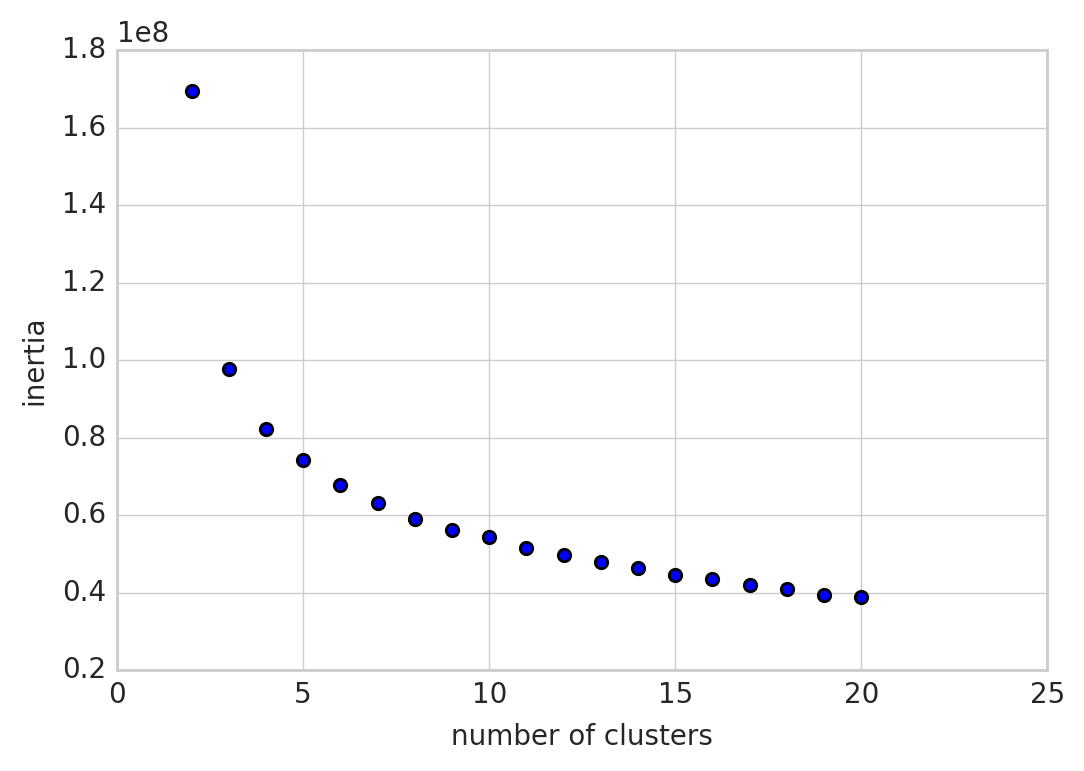

In [28]:
plt.scatter(range(2,21),j_inertia[1:20])
plt.xlabel('number of clusters')
plt.ylabel('inertia')

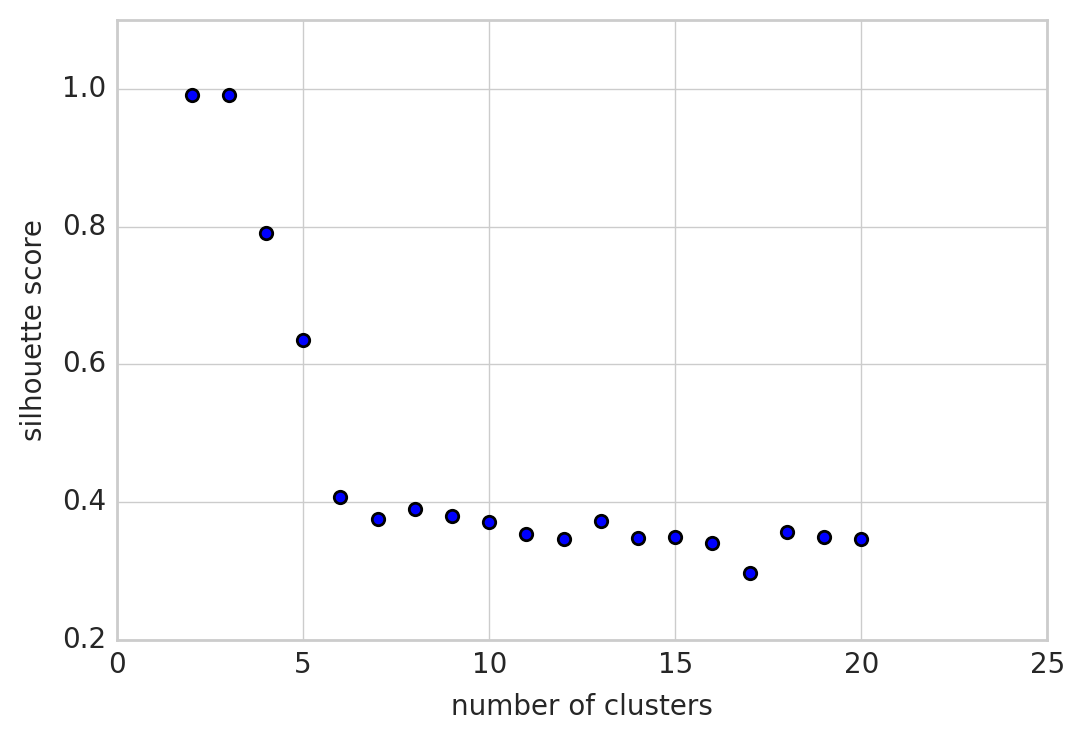

In [29]:
plt.scatter(range(2,21),j_silhouette[0:19])
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')

In [30]:
j_means[3].cluster_centers_

array([[  3.01886282e+01,   3.94452467e+01,   2.64572804e+01, ...,
          5.21660650e-01,   3.73044525e-02,   1.53429603e-02],
       [  2.89750792e+01,   3.98035951e+01,   2.46964559e+01, ...,
          1.13471556e-01,   4.17730569e-02,   2.34909611e-02],
       [  2.91403829e+01,   3.88860529e+01,   2.48359161e+01, ...,
          2.21513218e-01,   1.01185050e-01,   4.74020055e-02],
       [  2.89830601e+01,   3.87775956e+01,   2.49677596e+01, ...,
          2.84153005e-01,   1.01092896e-01,   5.30054645e-02],
       [  2.95212364e+01,   3.96272467e+01,   2.51927876e+01, ...,
          2.65025758e-01,   1.77561534e-01,   8.44876932e-02]])

In [31]:
j_means[3].cluster_centers_.shape

(5, 4842)

In [32]:
cluster_center_df=pd.DataFrame(j_means[3].cluster_centers_,columns=okc3_dummies.columns)
cluster_center_df

,d_age,lf_max_age,lf_min_age,q255,p_sprit,p_oldfash,p_pure,p_sexdrive,"q34113_It's okay, if it is not abused",q34113_Never - Get a job,...,q1112_Yes,q53965_0,q53965_Catch it and put it outside.,q53965_Find someone else to deal with it.,q53965_Ignore it.,q53965_Kill it.,q32_0,q32_I have little or no interest.,q32_I have tried it.,q32_It seriously interests me.
0,30.188628,39.445247,26.457280,8.953931e+04,22.452166,36.459386,29.098977,-34.939832,0.379663,0.441937,...,0.247593,0.438026,0.124549,0.137786,0.064380,0.235259,0.425692,0.521661,0.037304,0.015343
1,28.975079,39.803595,24.696456,-2.095476e-09,1.782147,0.897457,-0.524563,-3.717904,0.086712,0.825043,...,0.122153,0.820447,0.056174,0.041671,0.030028,0.051680,0.821264,0.113472,0.041773,0.023491
2,29.140383,38.886053,24.835916,9.854700e+04,9.268004,6.186873,-0.457612,-3.494986,0.228806,0.637192,...,0.185962,0.651778,0.076572,0.090246,0.050137,0.131267,0.629900,0.221513,0.101185,0.047402
3,28.983060,38.777596,24.967760,8.975400e+04,9.078689,7.848634,-1.490164,-5.327322,0.246448,0.598907,...,0.220219,0.632787,0.093989,0.094536,0.045355,0.133333,0.561749,0.284153,0.101093,0.053005
4,29.521236,39.627247,25.192788,8.954234e+04,-2.801488,-7.330052,-14.801259,8.954894,0.309330,0.440412,...,0.356382,0.450258,0.173097,0.106354,0.105323,0.164969,0.472925,0.265026,0.177562,0.084488


#### For the next step, I manipulate the cluster labels and concatenate them to the original data table.

In [33]:
#These labels indicate which cluster each profile belongs to
j_means[3].labels_

array([4, 0, 1, ..., 1, 1, 1], dtype=int32)

In [34]:
#Convert the label array into a dataframe
label_df=pd.DataFrame(j_means[3].labels_)
label_df.rename(index=str,columns={0:'cluster'},inplace=True)
label_df.head()

,cluster
0,4
1,0
2,1
3,4
4,1


In [35]:
print(okc3.shape,label_df.shape)

((24777, 246), (24777, 1))


In [36]:
okc3_ri = okc3.reset_index(drop=True)

In [37]:
okc3_ri=okc3_ri.replace(to_replace=0,value=np.nan)

In [38]:
#Add the cluster labels to the dataframe of profiles
okc3_ri.loc[:, 'cluster_labels'] = label_df.cluster.tolist()

In [39]:
okc3_ri.cluster_labels=okc3_ri['cluster_labels'].apply(str)


In [40]:
okc3_ri.shape

(24777, 247)

In [41]:
okc3_ri.head()

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32,cluster_labels
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,NaN,Extremely important,Very important.,NaN,No,No,Yes,Catch it and put it outside.,I have little or no interest.,4
1,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,Complex,Not at all important,NaN,Wholesome,NaN,No,NaN,Find someone else to deal with it.,I have little or no interest.,0
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


#### Count how many profiles are in each cluster.

In [42]:

x=okc3_ri.groupby(['cluster_labels'])['d_orientation'].count()
x

cluster_labels
0    3392
1    9791
2    1097
3    1830
4    8667
Name: d_orientation, dtype: int64

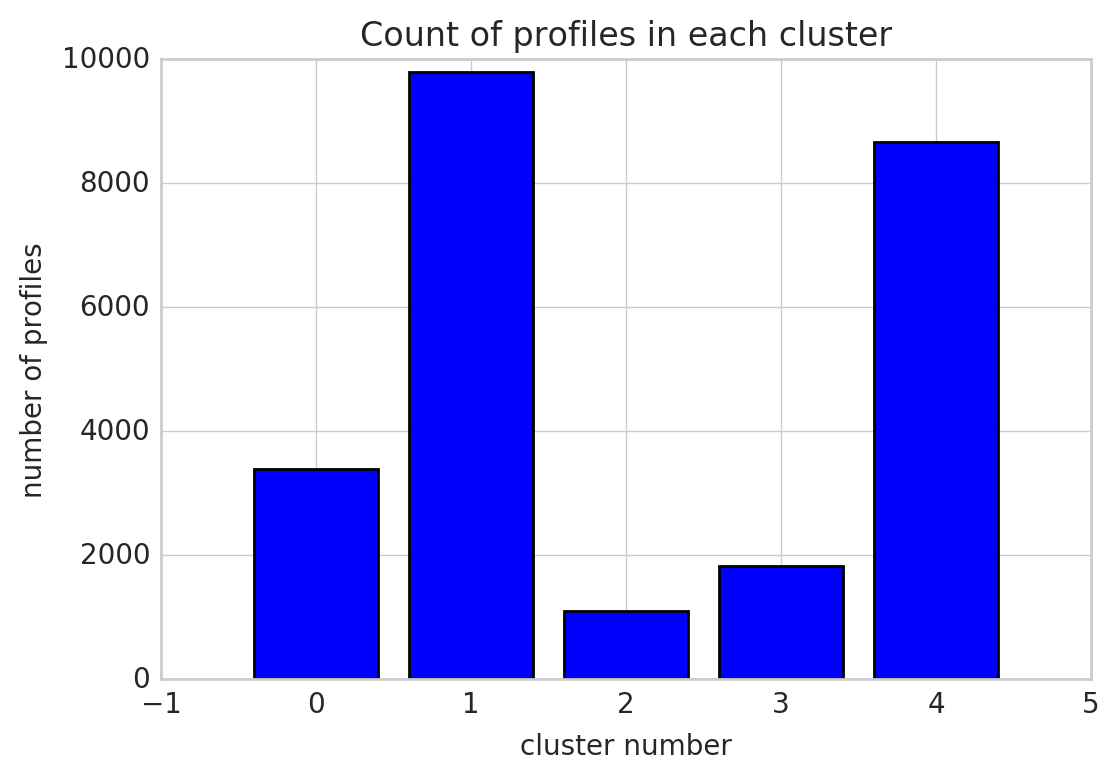

In [43]:
#Plot the count of profiles in each cluster
y_pos = np.arange(len(x))
plt.figure
#axes = plt.gca()
#axes.set_xlim([0,4])
#x1,x2,y1,y2 = plt.axis()

#plt.axis((0,4,y1,y2))
#set_xlim((0, 4))
#plt.axis([0,4, 0, 10000])
plt.xlabel('cluster number')
plt.ylabel('number of profiles')
plt.title('Count of profiles in each cluster')
plt.bar(y_pos,x,align='center')
plt.show()

In [44]:
okc3_ri.head()

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32,cluster_labels
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,NaN,Extremely important,Very important.,NaN,No,No,Yes,Catch it and put it outside.,I have little or no interest.,4
1,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,Complex,Not at all important,NaN,Wholesome,NaN,No,NaN,Find someone else to deal with it.,I have little or no interest.,0
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


#### Now, I want to replace the question numbers with the question text, which is available from the question table loaded earlier. 

In [114]:
questions[['q','text']].head()

,q,text
0,q2,Breast implants?
1,q11,How does the idea of being slapped hard in the...
2,q12,Divide your age by 2. Have you had sex with a...
3,q13,Is a girl who's slept with 100 guys a bad person?
4,q14,Is a guy who's slept with 100 girls a bad person?


#### Make a dictionary that relates the question numbers to the question text. 

In [46]:
new_col={}
for k in questions[['q','text']].as_matrix():
    
    new_col[k[0]]=k[1]
print(new_col)

{'q53910': 'How often do you read before going to sleep?', 'q6208': "You're in a serious relationship and your partner wants to know about your past relationships. The details are\xe2\x80\xa6", 'q81297': 'Would you consider dating someone who uses profanity more than not in everyday speech?', 'q78': 'Generally, do you enjoy being drunk?', 'q85886': 'Should laws that address nudity above the waist apply equally to males and females?', 'q47960': 'Imagine on your birthday you receive three books.  One is a religious text.  One is a scientific text.  One is a novel.  Without knowing anything more about the topics or authors, which do you think you would enjoy the most?', 'q58660': 'Is there any amount of money that could persuade you to murder someone whom you know nothing about?', 'q142190': 'Does your significant other need to be a virgin?', 'q18889': 'Do you feel comfortable in an educational or academic environment?', 'q85409': "While drinking in an out-of-the-way bar, you see a friend

In [47]:
#Rename the data columns with the question text
okc3_ri.rename(index=str, columns=new_col,inplace=True)


In [144]:
okc3_ri

,"How do you feel about government-subsidized food programs (free lunch, food stamps, etc.)?","Which type of wine would you prefer to drink outside of a meal, such as for leisure?",Do you like watching foreign movies with subtitles?,Gender,Type of match,Country,Age,Max age of match,Looking for match,Sexual orientation,...,Do you prefer the people in your life to be simple or complex?,How important is voting to you?,How important to you is being with family during holidays?,"If you had to pick one of the following types of people for a significant other, which would it be?",Do you feel there are any circumstances in which a person is obligated to have sex with you?,Do you have a child or children?,Do you like the taste of beer?,"If you discovered a spider on the wall in your bedroom, which would you do?",Group sex (with 3 or more people):,cluster_labels
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,NaN,Extremely important,Very important.,NaN,No,No,Yes,Catch it and put it outside.,I have little or no interest.,4
1,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,Complex,Not at all important,NaN,Wholesome,NaN,No,NaN,Find someone else to deal with it.,I have little or no interest.,0
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,"It's okay, if it is not abused","Red (such as Merlot, Cabernet, Shiraz).",Yes,Woman,Men who like women,Australia,25.0,30.0,"For new friends, long-term dating, short-term...",Straight,...,Complex,Extremely important,NaN,Crazy and colorful,No,NaN,NaN,NaN,I have little or no interest.,0
6,No problem,"White (such as Chardonnay, Riesling).",Yes,Woman,Everyone,Netherlands,28.0,38.0,For new friends,Bisexual,...,Complex,Very important,Somewhat important.,Wholesome,No,No,Yes,Catch it and put it outside.,I have tried it.,4
7,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Germany,24.0,34.0,"For long-term dating, short-term dating",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,21.0,28.0,"For new friends, long-term dating, short-term...",Bisexual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,UK,20.0,26.0,"For new friends, long-term dating, short-term...",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [133]:
okc3_ri2=okc3_ri.groupby(['cluster_labels']).count().reset_index(drop=False)
okc3_ri2

,cluster_labels,"How do you feel about government-subsidized food programs (free lunch, food stamps, etc.)?","Which type of wine would you prefer to drink outside of a meal, such as for leisure?",Do you like watching foreign movies with subtitles?,Gender,Type of match,Country,Age,Max age of match,Looking for match,...,"If you were visiting a new city, where would you be most excited to go?",Do you prefer the people in your life to be simple or complex?,How important is voting to you?,How important to you is being with family during holidays?,"If you had to pick one of the following types of people for a significant other, which would it be?",Do you feel there are any circumstances in which a person is obligated to have sex with you?,Do you have a child or children?,Do you like the taste of beer?,"If you discovered a spider on the wall in your bedroom, which would you do?",Group sex (with 3 or more people):
0,0,3392,3392,3392,3392,3392,3392,3392,3392,3392,...,1937,1863,1919,2000,1927,1809,1978,1926,1903,1943
1,1,9791,9791,9791,9791,9791,9791,9791,9791,9791,...,1786,1718,1657,1746,1688,1772,1789,1872,1758,1750
2,2,1097,1097,1097,1097,1097,1097,1097,1097,1097,...,383,414,410,396,393,365,369,371,382,406
3,3,1830,1830,1830,1830,1830,1830,1830,1830,1830,...,706,759,765,743,745,687,674,693,672,802
4,4,8667,8667,8667,8667,8667,8667,8667,8667,8667,...,4760,4807,4806,4667,4759,4875,4688,4622,4767,4570


#### In order to create a model profile for each cluster, I compute the mode for each feature.

In [48]:
#15 minutes for 5 clusters
df_list=[]
print('start '+'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
for k in range(0,5):
    print(k,'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    df=okc3_ri
    #df=df.sort_values(k,axis=1,ascending=False)
    df=df[df['cluster_labels']==str(k)]
  
    
    df=df.apply(mode)
    df_list.append(df)
    
print('end '+'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

start Timestamp: 2017-08-28 08:02:38
(0, 'Timestamp: 2017-08-28 08:02:38')
(1, 'Timestamp: 2017-08-28 08:02:40')
(2, 'Timestamp: 2017-08-28 08:02:58')
(3, 'Timestamp: 2017-08-28 08:02:59')
(4, 'Timestamp: 2017-08-28 08:03:01')
end Timestamp: 2017-08-28 08:03:12


In [150]:
#15 minutes for 5 clusters
dfx=pd.DataFrame(columns=['0: mode','0: count','1: mode','1: count','2: mode','2: count','3: mode','3: count','4: mode','4: count'])
print('start '+'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
for k in range(0,5):
    print(k,'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    df=okc3_ri
    #df=df.sort_values(k,axis=1,ascending=False)
    df=df[df['cluster_labels']==str(k)]
  
    
    df=df.apply(mode)
    i=str(k)+': mode'
    i2=str(k)+': count'
    print(i,i2)
    #print(df.mode,df.count)
    dfx[[i]]=df.mode
    dfx[[i2]]=df.count

print(dfx)
    
print('end '+'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

start Timestamp: 2017-08-27 05:00:23
(0, 'Timestamp: 2017-08-27 05:00:23')
('0: mode', '0: count')
(1, 'Timestamp: 2017-08-27 05:00:25')
('1: mode', '1: count')
(2, 'Timestamp: 2017-08-27 05:00:43')
('2: mode', '2: count')
(3, 'Timestamp: 2017-08-27 05:00:44')
('3: mode', '3: count')
(4, 'Timestamp: 2017-08-27 05:00:45')
('4: mode', '4: count')
Empty DataFrame
Columns: [0: mode, 0: count, 1: mode, 1: count, 2: mode, 2: count, 3: mode, 3: count, 4: mode, 4: count]
Index: []
end Timestamp: 2017-08-27 05:00:56


In [138]:
for k in df_list[0]:
    print(k)

ModeResult(mode=array(['Never - Get a job'], dtype=object), count=array([1502]))
ModeResult(mode=array(['Ros\xc3\xa9 (such as White Zinfindel).'], dtype=object), count=array([2352]))
ModeResult(mode=array(["Can't answer without a subtitle"], dtype=object), count=array([2227]))
ModeResult(mode=array(['Woman'], dtype=object), count=array([3392]))
ModeResult(mode=array(['Men'], dtype=object), count=array([2545]))
ModeResult(mode=array(['CA'], dtype=object), count=array([482]))
ModeResult(mode=array([29.0], dtype=object), count=array([268]))
ModeResult(mode=array([35.0], dtype=object), count=array([512]))
ModeResult(mode=array(['For  new friends, long-term dating, short-term dating'], dtype=object), count=array([1084]))
ModeResult(mode=array(['Straight'], dtype=object), count=array([3193]))
ModeResult(mode=array(['Single'], dtype=object), count=array([3379]))
ModeResult(mode=array(['Near me'], dtype=object), count=array([2749]))
ModeResult(mode=array([25.0], dtype=object), count=array([491

#### I now have a list of 5 optimized profiles. 

In [49]:
print(df_list[1]).head()

How do you feel about government-subsidized food programs (free lunch, food stamps, etc.)?                  ([Never - Get a job], [8078])
Which type of wine would you prefer to drink outside of a meal, such as for leisure?          ([Rosé (such as White Zinfindel).], [8968])
Do you like watching foreign movies with subtitles?                                           ([Can't answer without a subtitle], [8847])
Gender                                                                                                                  ([Woman], [9791])
Type of match                                                                                                             ([Men], [5707])
dtype: object


In [63]:
#sorted_df = df.sort_values(df.last_valid_index(), axis=1)
okc3_ri_sorted=okc3_ri2.sort_values(0,axis=1,ascending=False)
okc3_ri_sorted

ValueError: When sorting by column, axis must be 0 (rows)

#### I tried out K-Modes as described in the Wired article. However, it took an hour to compute the clusters for just one cluster count and the silhouette score was poor. 

In [52]:
from kmodes import kmodes


In [53]:
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
km = kmodes.KModes(n_clusters=5)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
clusters_km = km.fit_predict(okc3_dummies)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

Timestamp: 2017-08-28 08:05:01
Timestamp: 2017-08-28 08:05:01
Timestamp: 2017-08-28 08:52:15


In [60]:
clusters_km

array([2, 2, 0, ..., 0, 0, 0], dtype=uint8)

In [63]:
km_silhouette=silhouette_score(okc3_dummies,clusters_km)
km

KModes(cat_dissim=<function matching_dissim at 0x7fbfe06c5758>, init='Cao',
    max_iter=100, n_clusters=5, n_init=1, verbose=0)

In [64]:
km_silhouette

-0.11705389286960151

In [ ]:

def plot_dendrogram(df):
    
    # Data prep
    X = df.as_matrix(columns=None)
    Z = linkage(X, 'ward')
    
    # plotting
    plt.figure(figsize = (12,6))
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        leaf_rotation=0.,  
        leaf_font_size=20.,
    )
    
    plt.show()
    return Z

In [ ]:
import datetime
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
Z1=plot_dendrogram(okc3_dummies)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

In [ ]:
import hdbscan
import datetime


In [ ]:
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
cluster_labels = clusterer.fit_predict(okc3_dummies)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))